<a href="https://colab.research.google.com/github/baalasangar/MLAI/blob/master/13_Capstone/Model_building_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective:
 - Train  a neural network model which can predict is the patience is affected or not.
 - sample images are taken from the population ( considering the distripution of the data like *****)
 - sample  Train Image - 500 postive images 500 negative images
 - sample Test Image - 50 postive and 50 negative images
 - xray images of 512 * 512 are the input to the model
 - evaluation metrics - recall
 - conclution is performed with comparing different models ( classification metrix, loss vs accuracy & classification report ) 






### Load lib and data

In [1]:
!pip install pydicom

     |████████████████████████████████| 1.9 MB 8.1 MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score,precision_score,roc_auc_score,accuracy_score,confusion_matrix,roc_curve,plot_roc_curve


import cv2
import pydicom as dicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import pickle

import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s :: %(levelname)s :: %(message)s')



import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,BatchNormalization,Flatten,Conv2D,MaxPooling2D,MaxPool2D,GlobalMaxPooling2D,Input
from tensorflow.keras.optimizers import SGD,RMSprop,Adam
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2


In [4]:
RANDOM_SEED = 39
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
META_DATA = "/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv"
DATA_ROOT_PATH = "/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/"


META_DATA,DATA_ROOT_PATH

('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/final_data.csv',
 '/content/drive/MyDrive/GreatLearning/Captone_project/Pneumonia _DS/')

In [6]:
metadata_df = pd.read_csv(META_DATA)
metadata_df.drop(labels= ["Unnamed: 0"], axis=1,inplace=True)
metadata_df.head()

,patientId,x,y,width,height,Target,class,filepath,Train_or_Test,area,age,sex,ViewPosition,BodyPartExamined
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,51,F,PA,CHEST
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,48,F,PA,CHEST
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,19,M,AP,CHEST
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,NaN,28,M,PA,CHEST
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,/content/drive/MyDrive/GreatLearning/Captone_p...,Train,80727.0,32,F,AP,CHEST


### sample data for model building
 - from EDA , ViewPosition  ( PA and AP  ) influence the orientation of the xray . So the sampling is done by considering  ViewPosition

2021-08-21 14:21:10,109 :: INFO :: NumExpr defaulting to 4 threads.


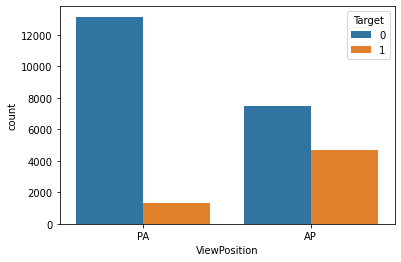

In [7]:
sns.countplot(data = metadata_df[["patientId","Target","ViewPosition"]].drop_duplicates(),x="ViewPosition",hue="Target")
plt.show()

In [8]:
SAMPLE_SIZE = 5000
sampled_metadata = pd.DataFrame(columns=["patientId","Target","ViewPosition","filepath"])

In [9]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 1")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


1100 3900


In [10]:
pa_count = metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]
ap_count = metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition"]].drop_duplicates().shape[0]

pa_count_sample_size = int(round(pa_count / (pa_count+ap_count),2) * SAMPLE_SIZE)
ap_count_sample_size = int(round(ap_count / (pa_count+ap_count),2) * SAMPLE_SIZE)

print(pa_count_sample_size,ap_count_sample_size)

sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'PA' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=pa_count_sample_size,random_state=RANDOM_SEED))
sampled_metadata = sampled_metadata.append(metadata_df.query("ViewPosition == 'AP' & Target == 0")[["patientId","Target","ViewPosition","filepath"]].drop_duplicates().sample(n=ap_count_sample_size,random_state=RANDOM_SEED))


3200 1800


In [11]:
sampled_metadata.reset_index(drop=True,inplace=True )
print(sampled_metadata.shape)
sampled_metadata.head()

(10000, 4)


,patientId,Target,ViewPosition,filepath
0,bee9c557-4bce-435f-8de8-bfb37663ccc6,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
1,ac7a86f8-447e-4062-9ed3-2361a6ea7fdc,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
2,580ac649-504a-472d-abb8-0d53d82fc801,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
3,ab6e779b-d387-46fe-be63-74bb6c2a1d08,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...
4,49f0fa25-89cd-41a7-9c70-4d7d8d9be572,1,PA,/content/drive/MyDrive/GreatLearning/Captone_p...


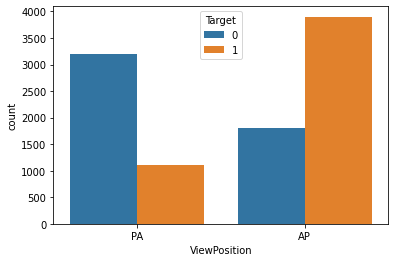

In [12]:
# distibution of the sample dataset similar to the population 

sns.countplot(data = sampled_metadata,x="ViewPosition",hue="Target")

### reading , postprocessing, reshaping Img

In [13]:
### reading the image and storing it as pickle for later access

# def read_img(index_list):
#   image_list = []
#   label_list = []
#   for index in index_list:
#     filePath = sampled_metadata.loc[index]["filepath"]
#     image_list.append(dicom.dcmread(filePath).pixel_array)
#     label_list.append(sampled_metadata.loc[index]["Target"])
#   return image_list,label_list

# index_list = list(sampled_metadata.index)
# X,y = read_img(index_list)
# X = np.array(X)
# y = np.array(y)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','wb') as f:
#   pickle.dump(X, f,pickle.HIGHEST_PROTOCOL)

# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','wb') as f:
#   pickle.dump(y, f,pickle.HIGHEST_PROTOCOL)  

#### reading img

In [14]:
with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/image_list.pkl','rb') as f:
  X_image_list = pickle.load(f)

with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/label_list.pkl','rb') as f:
  y_lable_value = pickle.load(f)

In [15]:
X_image_list.shape

(10000, 1024, 1024)

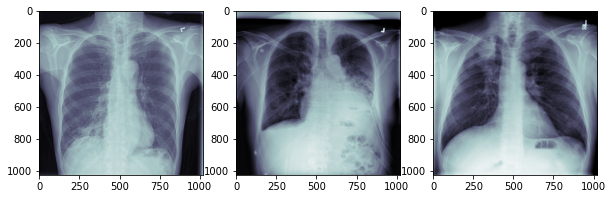

In [16]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### CLAHE processing - improve the contrast of images
 - Contrast Limited Adaptive Histogram Equalization (CLAHE) to equalize images. CLAHE is a variant of Adaptive histogram equalization (AHE) which takes care of over-amplification of the contrast
 

In [17]:
def CLAHEprocessing(img):
  clahe = cv2.createCLAHE(clipLimit = 5)
  clahe_img = clahe.apply(img) + 30
  return clahe_img

X_image_list = [CLAHEprocessing(img) for img in X_image_list]

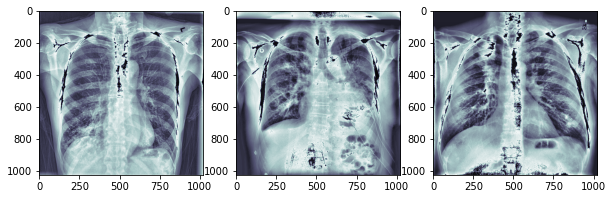

In [18]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_list[i],"bone") 
plt.show()

#### reshaping image

In [19]:
IMG_HEIGHT_WIDTH = 150
# resizing the image 512 * 512
X_image_reshaped = [cv2.resize(img,(IMG_HEIGHT_WIDTH,IMG_HEIGHT_WIDTH)) for img in X_image_list]
print("Shape of the image after resizing", X_image_reshaped[0].shape)

Shape of the image after resizing (150, 150)


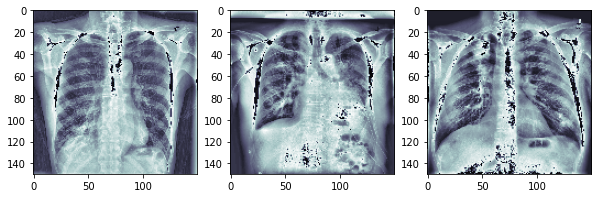

In [20]:
plt.figure(figsize=(10, 10))
for i in range(0,3):
  ax = plt.subplot(1, 3, i + 1)
  plt.imshow(X_image_reshaped[i],"bone") 
plt.show()

In [21]:
# index = list(sampled_metadata.query("patientId == 'e18c7203-a029-4cf4-8151-2bc2460c390c'").index)
# testpath = sampled_metadata.loc[index[0]]["filepath"]
# img = dicom.dcmread(testpath).pixel_array
# # logging.info(testpath, testpath.dtype)
# # img = dicom.dcmread(testpath).pixel_array
# print(img.shape,img.min(),img.max())
# plt.imshow(img,"bone") 
# plt.show()

# img = cv2.resize(img,(512,512),interpolation = cv2.INTER_AREA)
# plt.imshow(img,"bone") 
# plt.show()
# print(img.shape,img.min(),img.max())


# clahe = cv2.createCLAHE(clipLimit = 5)
# clahe_img = clahe.apply(img) + 30
# plt.imshow(clahe_img,"bone") 
# plt.show()


### Train & test data split

In [22]:
X_train, X_test_validate, y_train, y_test_validate = train_test_split(np.array(X_image_reshaped), y_lable_value, test_size=0.3, random_state=RANDOM_SEED,stratify=y_lable_value)

X_test, X_validate, y_test, y_validate = train_test_split(X_test_validate, y_test_validate, test_size=0.2, random_state=RANDOM_SEED,stratify=y_test_validate)



In [23]:
print("X_train data shape ", X_train.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test.shape)
print("y_test data shape ", y_test.shape)

print("X_validate data shape ", X_validate.shape)
print("y_validate data shape ", y_validate.shape)


X_train data shape  (7000, 150, 150)
y_train data shape  (7000,)
X_test data shape  (2400, 150, 150)
y_test data shape  (2400,)
X_validate data shape  (600, 150, 150)
y_validate data shape  (600,)


In [24]:
print("distribution in Train \n", np.array(np.unique(y_train, return_counts=True)).T)
print("distribution in Test \n", np.array(np.unique(y_test, return_counts=True)).T)
print("distribution in Validate \n", np.array(np.unique(y_validate, return_counts=True)).T)

distribution in Train 
 [[   0 3500]
 [   1 3500]]
distribution in Test 
 [[   0 1200]
 [   1 1200]]
distribution in Validate 
 [[  0 300]
 [  1 300]]


### Normalize the image

In [25]:
normalizeimg = lambda x: (np.array(x) / 255.0).astype('float32')

## Normalize 
X_train = normalizeimg(X_train)
X_test = normalizeimg(X_test)
X_validate = normalizeimg(X_validate)

print("X_train min / max ", X_train.min(),X_train.max())
print("X_test min / max ", X_test.min(),X_test.max())
print("X_test min / max ", X_validate.min(),X_validate.max())

X_train min / max  0.0 1.0
X_test min / max  0.0 1.0
X_test min / max  0.0 1.0


### Reshape image to ( h*w) -> (h *w *c)

In [26]:
f_resize = lambda x: np.array(x).reshape(-1, IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH, 1)

X_train_nn = f_resize(X_train)
X_test_nn = f_resize(X_test)
X_validate_nn = f_resize(X_validate)

print("X_train data shape ", X_train_nn.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test_nn.shape)
print("y_test data shape ", y_test.shape)

print("X_validate data shape ", X_validate_nn.shape)
print("y_validate data shape ", y_validate.shape)

X_train data shape  (7000, 150, 150, 1)
y_train data shape  (7000,)
X_test data shape  (2400, 150, 150, 1)
y_test data shape  (2400,)
X_validate data shape  (600, 150, 150, 1)
y_validate data shape  (600,)


In [27]:
metrics_data = pd.DataFrame(columns=["model","train_score","test_score","validate_score","auc","recall","precision","cm"])

# def get_metrics(model_name):
#   metric = {
#     "model":model_name,
#     "train_score":round(accuracy_score(y_train,y_train_predict),2),
#     "test_score":round(accuracy_score(y_test,y_predict),2),
#     "auc":round(roc_auc_score(y_test,y_predict),2),
#     "recall":round(recall_score(y_test,y_predict),2),
#     "precision":round(precision_score(y_test,y_predict),2),
#     "cm":confusion_matrix(y_test,y_predict)
#     }
#   return metric


def plot_roccurve(y_true, y_score):
    """plot_roc_curve."""
    false_positive_rate, true_positive_rate, thresholds = roc_curve(
        y_true, y_score)
    plt.plot(false_positive_rate, true_positive_rate, lw=2, color='navy')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.ylim([-0.05, 1.05])
    plt.xlim([-0.05, 1.05])
    plt.grid()
    plt.title('Receiver operating characteristic AUC={0:0.2f}'.format(
        roc_auc_score(y_true, y_score))) 
    return plt


#### SVC + PCA

In [28]:
# ### Reshape input for  SVC 
# X_train_svc = X_train.reshape(X_train.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
# print("X_train_svc data shape ", X_train_svc.shape)

# X_test_svc= X_test.reshape(X_test.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
# print("X_test_svc data shape ", X_test_svc.shape)

# X_validate_svc= X_validate.reshape(X_validate.shape[0],IMG_HEIGHT_WIDTH*IMG_HEIGHT_WIDTH)
# print("X_validate_svc data shape ", X_validate_svc.shape)

# print("y_train data shape ", y_train.shape)
# print("y_test data shape ", y_test.shape)
# print("y_test data shape ", y_validate.shape)


# pca = PCA(0.95)
# estimator = SVC(kernel="rbf")
# param_grid = {    
#     "estimator__C":[1],
#     "estimator__gamma":[0.001],

# }
# pipe = Pipeline(steps=[('pca', pca), ('estimator', estimator)])
# gridsearch = GridSearchCV(pipe, param_grid, n_jobs=-1,scoring = "recall")
# gridsearch.fit(X_train_svc,y_train)


# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/svc_model.pkl','wb') as f:
#   pickle.dump(best_estimator_, f,pickle.HIGHEST_PROTOCOL)


In [29]:
# with open('/content/drive/MyDrive/GreatLearning/Captone_project/Code/Baala/svc_model.pkl','rb') as f:
#   svc_model = pickle.load(f)

# y_predict = svc_model.predict(X_test_svc)
# y_train_predict = svc_model.predict(X_train_svc)
# y_validate_predict = svc_model.predict(X_validate_svc)

In [30]:
# model_name = "SVC+PCA"
 
# metric = {
#     "model":model_name,
#     "train_score":round(accuracy_score(y_train,y_train_predict),2),
#     "test_score":round(accuracy_score(y_test,y_predict),2),
#     "validate_score":round(accuracy_score(y_validate,y_validate_predict),2)
#     "auc":round(roc_auc_score(y_validate,y_validate_predict),2),
#     "recall":round(recall_score(y_validate,y_validate_predict),2),
#     "precision":round(precision_score(y_validate,y_validate_predict),2),
#     "cm":confusion_matrix(y_validate,y_validate_predict)
#     }
# metrics_data = metrics_data.append(metric,ignore_index = True)
# metrics_data[metrics_data["model"] == model_name]


# print("Best param ", gridsearch.best_params_)
# print(" \n")

# fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
# sns.heatmap(confusion_matrix(y_test,y_predict),annot=True,ax=ax[0],cmap="YlGnBu")
# ax[0].set_title('Confusion Matrix'); 
# ax[1] = plot_roccurve(y_test,y_predict)
# plt.show() 


#### Neural Network

In [31]:
# def nn_model_dropout(kernel_initializer = "normal"):
#     model = Sequential()
#     model.add(Flatten())

#     model.add(Dense(512, activation = "relu"))   
#     model.add(BatchNormalization())

#     model.add(Dense(256, activation = "relu"))   
#     model.add(BatchNormalization())
    
#     model.add(Dense(128, activation = "relu"))   
#     model.add(BatchNormalization())
#     model.add(Dropout(0.2))

#     model.add(Dense(64, activation = "relu"))   
#     model.add(BatchNormalization())

#     model.add(Dense(32, activation = "relu"))   
#     model.add(BatchNormalization())
    
#     model.add(Dense(1, activation = "sigmoid"))
#     return model


# def nn_model():
#   inputs = Input(shape=(IMG_HEIGHT_WIDTH, IMG_HEIGHT_WIDTH))
#   x = Flatten()(inputs)
#   x = Dense(units=512, activation='relu')(x)
#   x = Dropout(rate=0.7)(x)
#   x = Dense(units=128, activation='relu')(x)  
#   #x = Dropout(rate=0.5)(x)
#   x = Dense(units=64, activation='relu')(x)
#   x = Dense(units=32, activation='relu')(x)
#   x = Dense(units=16, activation='relu')(x)
#   x = Dropout(rate=0.1)(x)

#   output = Dense(units=1, activation='sigmoid')(x)
#   model = Model(inputs=inputs, outputs=output)
#   return model

def nn_model():
  model = Sequential()
  model.add(Flatten())
  model.add(Dense(216,  activation = "relu"))   
  #model.add(BatchNormalization())
  #model.add(Dropout(0.2))
  
  model.add(Dense(128,  activation = "relu"))   
  #model.add(BatchNormalization())
  model.add(Dropout(0.2))

  model.add(Dense(64,  activation = "relu"))   
  #model.add(BatchNormalization())
  #model.add(Dropout(0.2))
  
  model.add(Dense(1, activation = "sigmoid"))
  return model



nn_model = nn_model()
optimizer = SGD(learning_rate=0.001,momentum=0.9  )

es = EarlyStopping(monitor='val_loss', patience=10,min_delta=0.0001)

nn_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.01, 
                                            min_lr=0.001)

fit_data = nn_model.fit(X_train_nn, y_train, validation_data=(X_test_nn,y_test),
                           batch_size = 32, epochs = 100, verbose = 1,callbacks=[es,learning_rate_reduction])

Epoch 1/100
219/219 [==============================] - 3s 5ms/step - loss: 0.6758 - accuracy: 0.5774 - val_loss: 0.6187 - val_accuracy: 0.6754
Epoch 2/100
219/219 [==============================] - 1s 4ms/step - loss: 0.6053 - accuracy: 0.6826 - val_loss: 0.6316 - val_accuracy: 0.6587
Epoch 3/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5949 - accuracy: 0.6953 - val_loss: 0.5730 - val_accuracy: 0.7113
Epoch 4/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5968 - accuracy: 0.6890 - val_loss: 0.5810 - val_accuracy: 0.7104
Epoch 5/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5772 - accuracy: 0.7060 - val_loss: 0.5688 - val_accuracy: 0.7100
Epoch 6/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5771 - accuracy: 0.7071 - val_loss: 0.5753 - val_accuracy: 0.7138
Epoch 7/100
219/219 [==============================] - 1s 4ms/step - loss: 0.5661 - accuracy: 0.7164 - val_loss: 0.5745 - val_accuracy: 0.7108

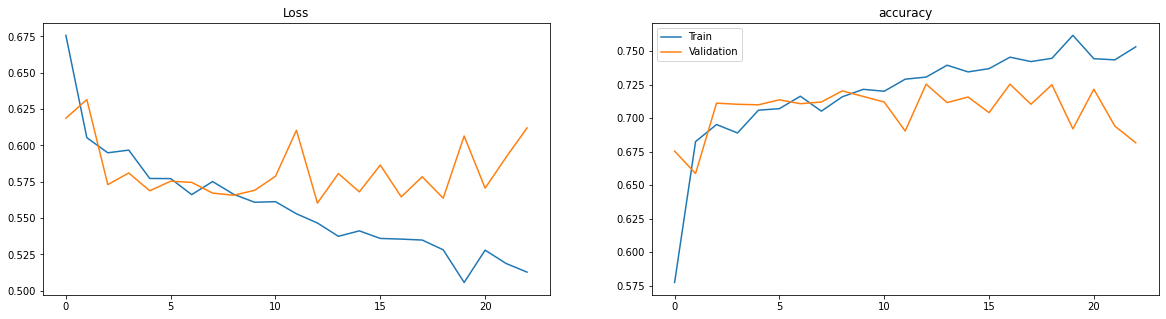

In [32]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


# ax[2].plot(fit_data.history['recall'],label="Train")
# ax[2].plot(fit_data.history['val_recall'],label="Validation")
# ax[2].set_title("recall")

# ax[3].plot(fit_data.history['precision'],label="Train")
# ax[3].plot(fit_data.history['val_precision'],label="Validation")
# ax[3].set_title("precision")
plt.legend()

plt.show() 

In [33]:
y_train_predict =  nn_model.predict(X_train_nn)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = nn_model.predict(X_test_nn)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = nn_model.predict(X_validate_nn)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]



model_name = "NN"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
0,NN,0.74,0.68,0.69,0.69,0.92,0.63,"[[135, 165], [23, 277]]"


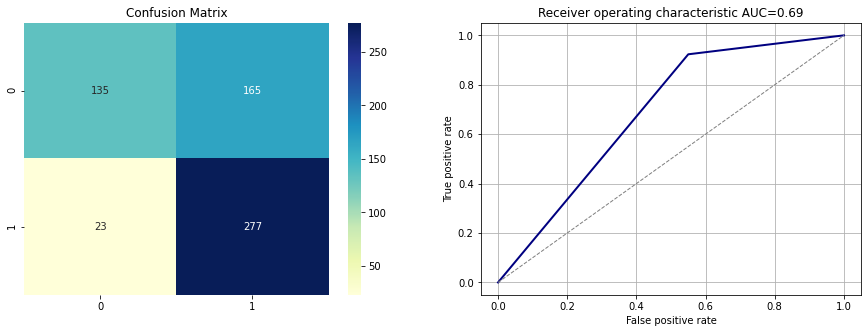

In [34]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

#### CNN ( with out transfer learning )

In [35]:
datagen = ImageDataGenerator(
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    zoom_range = 0.2,
)

datagen.fit(X_train_nn)


def cnn_model():
  model = Sequential()
  model.add(Conv2D(32, (3,3), strides = 1, padding='same', activation='relu', input_shape=(IMG_HEIGHT_WIDTH,IMG_HEIGHT_WIDTH,1)))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(64, (3,3), strides=1 ,padding='same', activation='relu'))
  model.add(Dropout(0.1))
  model.add(BatchNormalization())

  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(64, (3,3), strides=1, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(128, (3,3), strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Conv2D(256, (3,3), strides=1, padding='same', activation='relu'))
  model.add(Dropout(0.2))
  model.add(BatchNormalization())

  model.add(MaxPool2D((2,2), strides=2, padding='same'))
  model.add(Flatten())
  model.add(Dense(units=128, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(units = 1, activation='sigmoid'))
  return model

cnn_model = cnn_model()
optimizer = RMSprop(learning_rate=0.001)

es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)

cnn_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy"])

# learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
#                                             patience=3, 
#                                             verbose=1, 
#                                             factor=0.01, 
#                                             min_lr=0.0001)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.3, min_lr=0.000001)



fit_data = cnn_model.fit(datagen.flow(X_train_nn, y_train, batch_size=32, shuffle=True),epochs=100, 
    validation_data = (X_test_nn, y_test), callbacks=[es,learning_rate_reduction])

Epoch 1/100
219/219 [==============================] - 43s 93ms/step - loss: 0.8289 - accuracy: 0.6609 - val_loss: 0.6869 - val_accuracy: 0.5046
Epoch 2/100
219/219 [==============================] - 19s 89ms/step - loss: 0.5833 - accuracy: 0.7191 - val_loss: 0.6287 - val_accuracy: 0.6679
Epoch 3/100
219/219 [==============================] - 20s 92ms/step - loss: 0.5614 - accuracy: 0.7286 - val_loss: 0.5496 - val_accuracy: 0.7146
Epoch 4/100
219/219 [==============================] - 20s 92ms/step - loss: 0.5450 - accuracy: 0.7389 - val_loss: 0.5621 - val_accuracy: 0.7542
Epoch 5/100
219/219 [==============================] - 20s 93ms/step - loss: 0.5420 - accuracy: 0.7400 - val_loss: 0.6167 - val_accuracy: 0.6837
Epoch 6/100
219/219 [==============================] - 20s 92ms/step - loss: 0.5311 - accuracy: 0.7487 - val_loss: 0.5277 - val_accuracy: 0.7558
Epoch 7/100
219/219 [==============================] - 20s 92ms/step - loss: 0.5252 - accuracy: 0.7504 - val_loss: 0.6496 - val_ac

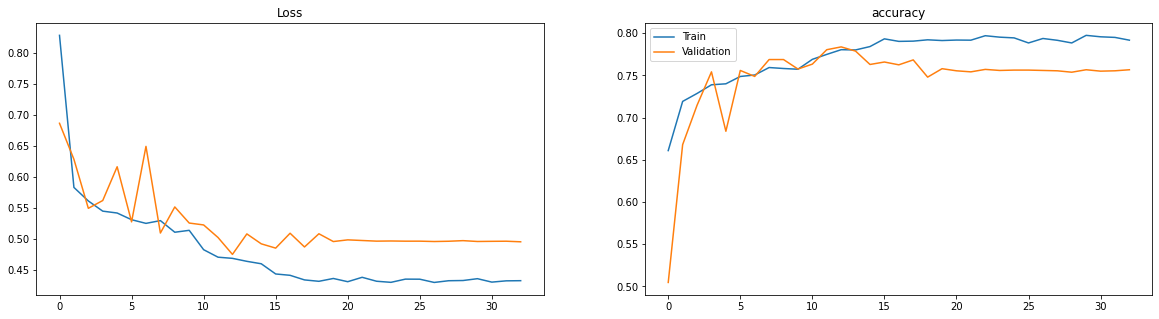

In [36]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


# ax[2].plot(fit_data.history['recall'],label="Train")
# ax[2].plot(fit_data.history['val_recall'],label="Validation")
# ax[2].set_title("recall")

# ax[3].plot(fit_data.history['precision'],label="Train")
# ax[3].plot(fit_data.history['val_precision'],label="Validation")
# ax[3].set_title("precision")
plt.legend()

plt.show() 

In [37]:
y_train_predict =  cnn_model.predict(X_train_nn)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = cnn_model.predict(X_test_nn)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = cnn_model.predict(X_validate_nn)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]



model_name = "CNN"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
1,CNN,0.78,0.76,0.7,0.7,0.58,0.76,"[[246, 54], [126, 174]]"


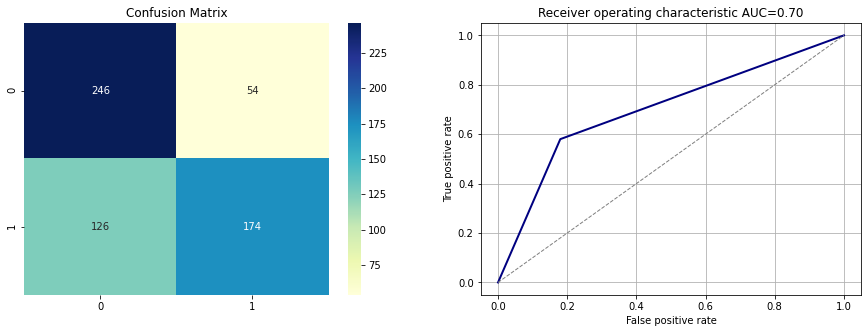

In [38]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

#### Transfer Learning

In [39]:
X_train_rgb = np.repeat(X_train[..., np.newaxis], 3, -1)
X_test_rgb = np.repeat(X_test[..., np.newaxis], 3, -1)
X_validate_rgb = np.repeat(X_validate[..., np.newaxis], 3, -1)



print("X_train data shape ", X_train_rgb.shape)
print("y_train data shape ", y_train.shape)

print("X_test data shape ", X_test_rgb.shape)
print("y_test data shape ", y_test.shape)

print("X_validate data shape ", X_validate_rgb.shape)
print("y_validate data shape ", y_validate.shape)

X_train data shape  (7000, 150, 150, 3)
y_train data shape  (7000,)
X_test data shape  (2400, 150, 150, 3)
y_test data shape  (2400,)
X_validate data shape  (600, 150, 150, 3)
y_validate data shape  (600,)


##### VGG16

In [40]:
from tensorflow.keras.applications  import VGG16,VGG19

In [41]:
# https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images/51996037

# https://stackoverflow.com/questions/51995977/how-can-i-use-a-pre-trained-neural-network-with-grayscale-images/51996037

In [42]:
vgg16 = VGG16(include_top = False,
                 weights = 'imagenet',
                 input_shape = (IMG_HEIGHT_WIDTH , IMG_HEIGHT_WIDTH, 3))

for layer in vgg16.layers:
    layer.trainable = False

#define model architecture
vgg16_model = Sequential()
vgg16_model.add(vgg16)

#fully connected layer
vgg16_model.add(Flatten())
vgg16_model.add(Dense(128, activation = 'relu'))
vgg16_model.add(BatchNormalization())
vgg16_model.add(Dense(64, activation = 'relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(Dense(32, activation = 'relu'))
vgg16_model.add(BatchNormalization())

vgg16_model.add(Dense(16, activation = 'relu'))
vgg16_model.add(BatchNormalization())
                
vgg16_model.add(Dense(8, activation = 'relu'))
vgg16_model.add(BatchNormalization())

#vgg16_model.add(Dropout(0.1))

#output layer
vgg16_model.add(Dense(1, activation = 'sigmoid'))
vgg16_model.summary()


#optimizer = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)
vgg16_model.compile(optimizer = "adam", loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.2, min_lr=0.00001)

fit_data = vgg16_model.fit(X_train_rgb, y_train, batch_size=32,epochs=100, 
    validation_data = (X_test_rgb, y_test), callbacks=[es,learning_rate_reduction])
                
                

58900480/58889256 [==============================] - 0s 0us/step
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               1048704   
_________________________________________________________________
batch_normalization_5 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_6 (Batch (None, 64)                256       
_______________________________________________________

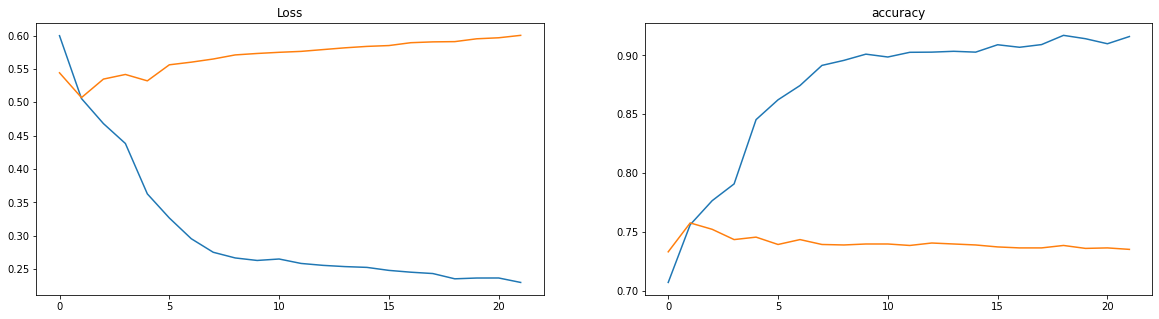

In [43]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


# ax[2].plot(fit_data.history['recall'],label="Train")
# ax[2].plot(fit_data.history['val_recall'],label="Validation")
# ax[2].set_title("recall")

# ax[3].plot(fit_data.history['precision'],label="Train")
# ax[3].plot(fit_data.history['val_precision'],label="Validation")
# ax[3].set_title("precision")
# plt.legend()

plt.show() 

In [44]:
y_train_predict =  vgg16_model.predict(X_train_rgb)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = vgg16_model.predict(X_test_rgb)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = vgg16_model.predict(X_validate_rgb)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]


model_name = "VGG16"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
2,VGG16,0.95,0.74,0.72,0.72,0.72,0.72,"[[217, 83], [84, 216]]"


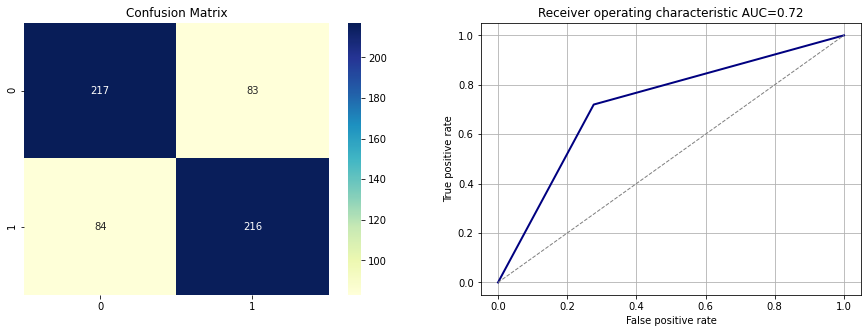

In [45]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

##### VGG19

In [46]:
vgg19 = VGG19(include_top = False,
                 weights = 'imagenet',
                 input_shape = (IMG_HEIGHT_WIDTH , IMG_HEIGHT_WIDTH, 3))

for layer in vgg19.layers:
    layer.trainable = False

#define model architecture
vgg19_model = Sequential()
vgg19_model.add(vgg19)


vgg19_model.add(Flatten())
vgg19_model.add(Dense(128, activation = 'relu'))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dense(64, activation = 'relu'))
vgg19_model.add(BatchNormalization())

vgg19_model.add(Dense(32, activation = 'relu'))
vgg19_model.add(BatchNormalization())

vgg19_model.add(Dense(16, activation = 'relu'))
vgg19_model.add(BatchNormalization())
                
vgg19_model.add(Dense(8, activation = 'relu'))
vgg19_model.add(BatchNormalization())

#vgg16_model.add(Dropout(0.1))

#output layer
vgg19_model.add(Dense(1, activation = 'sigmoid'))
vgg19_model.summary()


#output layer
vgg19_model.add(Dense(1, activation = 'sigmoid'))
#vgg16_model.summary()


optimizer = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)
vgg19_model.compile(optimizer = optimizer, loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.3, min_lr=0.00001)

fit_data = vgg19_model.fit(datagen.flow(X_train_rgb, y_train, batch_size=32, shuffle=True),epochs=100, 
    validation_data = (X_test_rgb, y_test), callbacks=[es,learning_rate_reduction])
                

80150528/80134624 [==============================] - 0s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               1048704   
_________________________________________________________________
batch_normalization_10 (Batc (None, 128)               512       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_11 (Batc (None, 64)                256       
_______________________________________________________

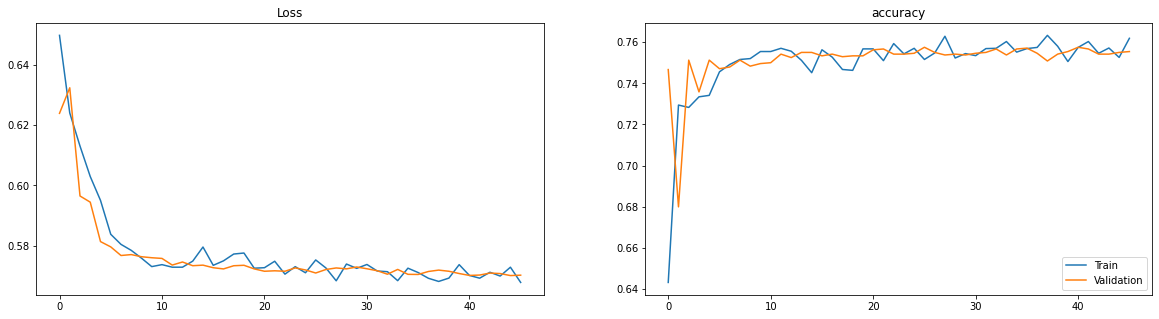

In [47]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


# ax[2].plot(fit_data.history['recall'],label="Train")
# ax[2].plot(fit_data.history['val_recall'],label="Validation")
# ax[2].set_title("recall")

# ax[3].plot(fit_data.history['precision'],label="Train")
# ax[3].plot(fit_data.history['val_precision'],label="Validation")
# ax[3].set_title("precision")
plt.legend()

plt.show() 

In [48]:
y_train_predict =  vgg19_model.predict(X_train_rgb)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = vgg19_model.predict(X_test_rgb)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = vgg19_model.predict(X_validate_rgb)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]


model_name = "VGG19"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
3,VGG19,0.77,0.76,0.74,0.74,0.68,0.78,"[[244, 56], [97, 203]]"


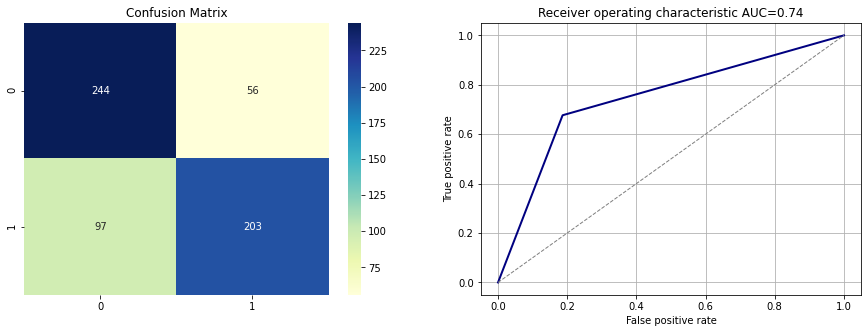

In [49]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

##### Resnet50

In [50]:
from tensorflow.keras.applications  import ResNet50,ResNet152 

In [51]:
resnet50 = ResNet50(include_top = False,
                 weights = 'imagenet',
                 input_shape = (IMG_HEIGHT_WIDTH , IMG_HEIGHT_WIDTH, 3))

for layer in resnet50.layers:
    layer.trainable = False

#define model architecture
resnet50_model = Sequential()
resnet50_model.add(resnet50)

#fully connected layer
resnet50_model.add(Flatten())
resnet50_model.add(Dense(128, activation = 'relu'))
resnet50_model.add(BatchNormalization())
resnet50_model.add(Dense(64, activation = 'relu'))
resnet50_model.add(BatchNormalization())

resnet50_model.add(Dense(32, activation = 'relu'))
resnet50_model.add(BatchNormalization())

resnet50_model.add(Dense(16, activation = 'relu'))
resnet50_model.add(BatchNormalization())
                
resnet50_model.add(Dense(8, activation = 'relu'))
resnet50_model.add(BatchNormalization())

resnet50_model.add(Dropout(0.1))

#output layer
resnet50_model.add(Dense(1, activation = 'sigmoid'))
resnet50_model.summary()


#optimizer = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)
resnet50_model.compile(optimizer = "sgd", loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.2, min_lr=0.00001)

fit_data = resnet50_model.fit(X_train_rgb, y_train, batch_size=16,epochs=100, 
    validation_data = (X_test_rgb, y_test), callbacks=[es,learning_rate_reduction])
                

94781440/94765736 [==============================] - 1s 0us/step
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 5, 5, 2048)        23587712  
_________________________________________________________________
flatten_4 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               6553728   
_________________________________________________________________
batch_normalization_15 (Batc (None, 128)               512       
_________________________________________________________________
dense_20 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_16 (Batc (None, 64)                256       
_______________________________________________________

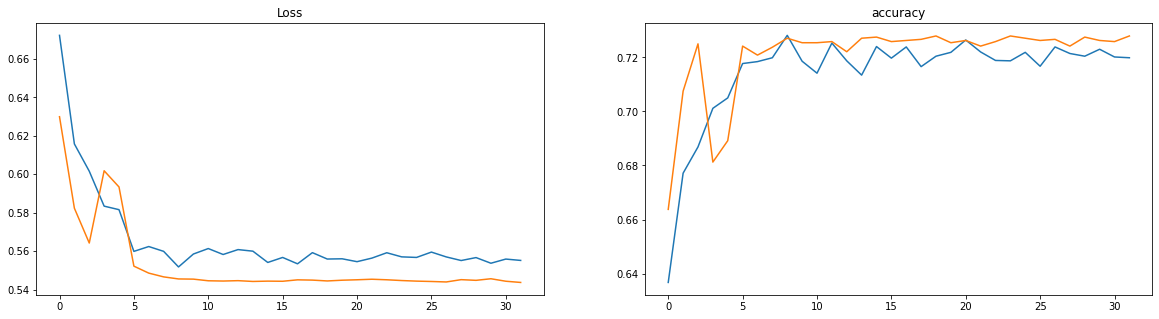

In [52]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")


# ax[2].plot(fit_data.history['recall'],label="Train")
# ax[2].plot(fit_data.history['val_recall'],label="Validation")
# ax[2].set_title("recall")

# ax[3].plot(fit_data.history['precision'],label="Train")
# ax[3].plot(fit_data.history['val_precision'],label="Validation")
# ax[3].set_title("precision")
# plt.legend()

plt.show() 

In [53]:
y_train_predict =  resnet50_model.predict(X_train_rgb)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = resnet50_model.predict(X_test_rgb)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = resnet50_model.predict(X_validate_rgb)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]


model_name = "ResNet50_V2"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
4,ResNet50_V2,0.74,0.73,0.7,0.7,0.7,0.71,"[[213, 87], [90, 210]]"


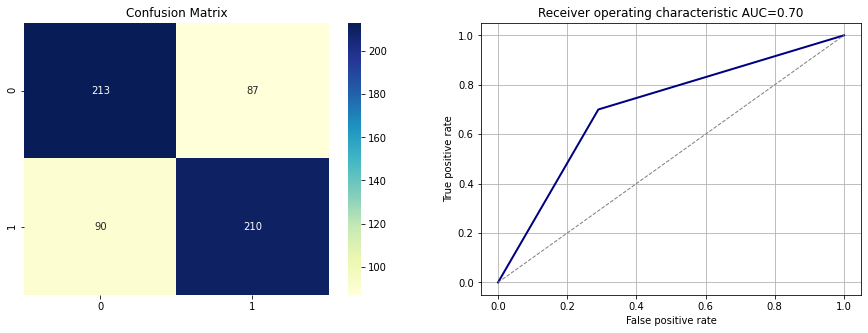

In [54]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

##### ResNet152 

In [55]:
resnet152 = ResNet152(include_top = False,
                 weights = 'imagenet',
                 input_shape = (IMG_HEIGHT_WIDTH , IMG_HEIGHT_WIDTH, 3))

for layer in resnet152.layers:
    layer.trainable = False

#define model architecture
resnet152_model = Sequential()
resnet152_model.add(resnet152)

#fully connected layer
resnet152_model.add(Flatten())
resnet152_model.add(Dense(128, activation = 'relu'))
resnet152_model.add(BatchNormalization())
resnet152_model.add(Dense(64, activation = 'relu'))
resnet152_model.add(BatchNormalization())

resnet152_model.add(Dense(32, activation = 'relu'))
resnet152_model.add(BatchNormalization())

resnet152_model.add(Dense(16, activation = 'relu'))
resnet152_model.add(BatchNormalization())
                
resnet152_model.add(Dense(8, activation = 'relu'))
resnet152_model.add(BatchNormalization())

resnet152_model.add(Dropout(0.1))

#output layer
resnet152_model.add(Dense(1, activation = 'sigmoid'))
resnet152_model.summary()


#optimizer = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)
resnet152_model.compile(optimizer = "sgd", loss= tf.keras.losses.BinaryCrossentropy(), 
                   metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.2, min_lr=0.00001)

fit_data = resnet152_model.fit(X_train_rgb, y_train, batch_size=16,epochs=100, 
    validation_data = (X_test_rgb, y_test), callbacks=[es,learning_rate_reduction])
                

234708992/234698864 [==============================] - 1s 0us/step
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet152 (Functional)       (None, 5, 5, 2048)        58370944  
_________________________________________________________________
flatten_5 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 128)               6553728   
_________________________________________________________________
batch_normalization_20 (Batc (None, 128)               512       
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_21 (Batc (None, 64)                256       
_____________________________________________________

Text(0.5, 1.0, 'accuracy')

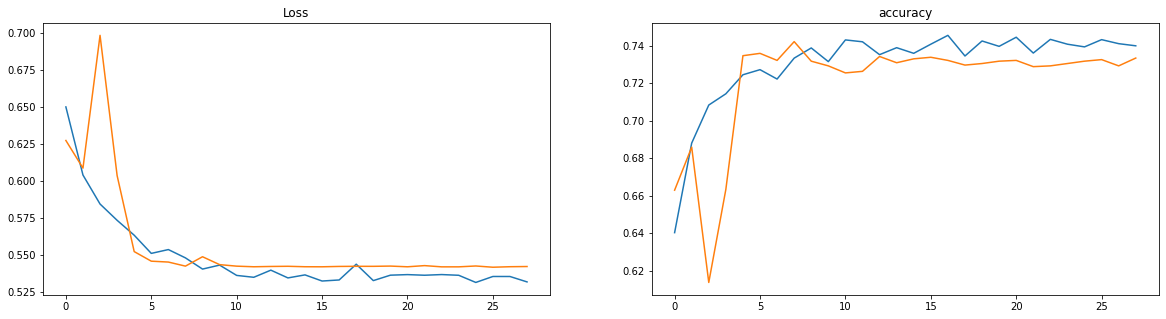

In [56]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")

In [57]:
y_train_predict =  resnet152_model.predict(X_train_rgb)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = resnet152_model.predict(X_test_rgb)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = resnet152_model.predict(X_validate_rgb)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]


model_name = "ResNet152"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
5,ResNet152,0.76,0.73,0.73,0.73,0.74,0.72,"[[214, 86], [78, 222]]"


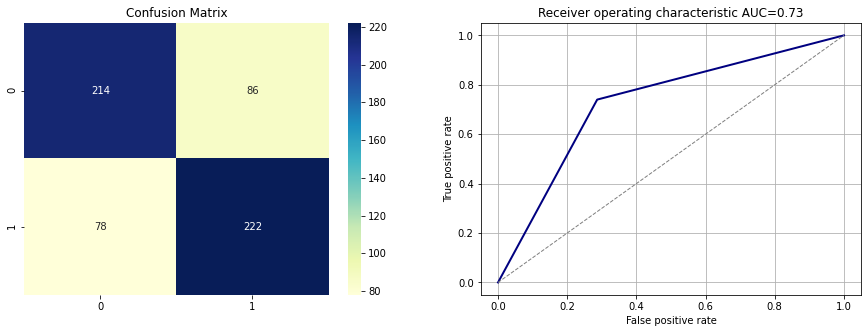

In [58]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

##### InceptionV3

In [59]:
from tensorflow.keras.applications  import InceptionV3

In [60]:
inceptionv3 = InceptionV3(include_top = False,
                 weights = 'imagenet',
                 input_shape = (IMG_HEIGHT_WIDTH , IMG_HEIGHT_WIDTH, 3),classes=2)

for layer in inceptionv3.layers:
    layer.trainable = False

#define model architecture
inceptionv3_model = Sequential()
inceptionv3_model.add(inceptionv3)

#fully connected layer
inceptionv3_model.add(Flatten())
inceptionv3_model.add(Dense(128, activation = 'relu'))
inceptionv3_model.add(BatchNormalization())
inceptionv3_model.add(Dense(64, activation = 'relu'))
inceptionv3_model.add(BatchNormalization())

inceptionv3_model.add(Dense(32, activation = 'relu'))
inceptionv3_model.add(BatchNormalization())

inceptionv3_model.add(Dense(16, activation = 'relu'))
inceptionv3_model.add(BatchNormalization())
                
inceptionv3_model.add(Dense(8, activation = 'relu'))
inceptionv3_model.add(BatchNormalization())

#vgg16_model.add(Dropout(0.1))

#output layer
inceptionv3_model.add(Dense(1, activation = 'sigmoid'))
inceptionv3_model.summary()


#optimizer = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)
inceptionv3_model.compile(optimizer = "sgd", loss= tf.keras.losses.BinaryCrossentropy(),metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

fit_data = inceptionv3_model.fit(X_train_rgb, y_train, batch_size=32,epochs=100, 
    validation_data = (X_test_rgb, y_test), callbacks=[es,learning_rate_reduction])
                

87924736/87910968 [==============================] - 0s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 3, 3, 2048)        21802784  
_________________________________________________________________
flatten_6 (Flatten)          (None, 18432)             0         
_________________________________________________________________
dense_31 (Dense)             (None, 128)               2359424   
_________________________________________________________________
batch_normalization_119 (Bat (None, 128)               512       
_________________________________________________________________
dense_32 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_120 (Bat (None, 64)                256       
_______________________________________________________

Text(0.5, 1.0, 'accuracy')

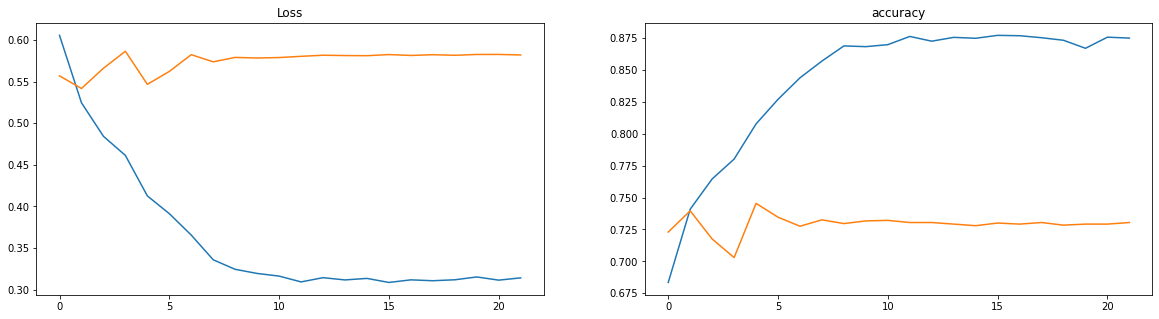

In [61]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")

In [62]:
y_train_predict =  inceptionv3_model.predict(X_train_rgb)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = inceptionv3_model.predict(X_test_rgb)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = inceptionv3_model.predict(X_validate_rgb)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]


model_name = "Inceptionv3"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
6,Inceptionv3,0.91,0.73,0.7,0.7,0.74,0.69,"[[198, 102], [77, 223]]"


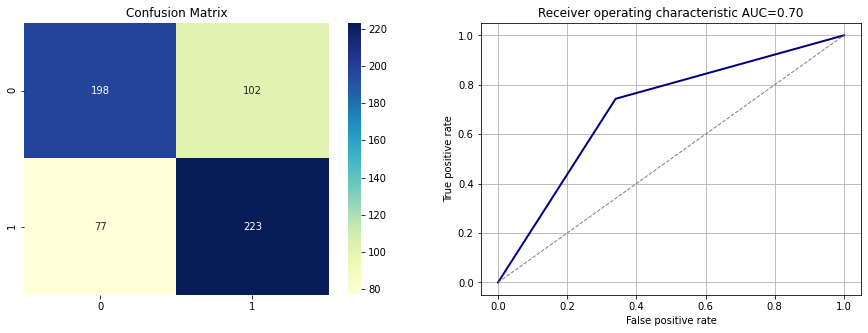

In [63]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

##### Xception

In [64]:
from tensorflow.keras.applications  import Xception

In [65]:
xception = Xception(include_top = False,
                 weights = 'imagenet',
                 input_shape = (IMG_HEIGHT_WIDTH , IMG_HEIGHT_WIDTH, 3),classes=2)

for layer in xception.layers:
    layer.trainable = False

#define model architecture
xception_model = Sequential()
xception_model.add(xception)

#fully connected layer
xception_model.add(Flatten())
xception_model.add(Dense(128, activation = 'relu'))
xception_model.add(BatchNormalization())
xception_model.add(Dense(64, activation = 'relu'))
xception_model.add(BatchNormalization())

xception_model.add(Dense(32, activation = 'relu'))
xception_model.add(BatchNormalization())

xception_model.add(Dense(16, activation = 'relu'))
xception_model.add(BatchNormalization())
                
xception_model.add(Dense(8, activation = 'relu'))
xception_model.add(BatchNormalization())

#vgg16_model.add(Dropout(0.1))

#output layer
xception_model.add(Dense(1, activation = 'sigmoid'))
xception_model.summary()


#optimizer = Adam(learning_rate=0.001)
es = EarlyStopping(monitor='val_loss', patience=20,min_delta=0.001)
xception_model.compile(optimizer = "sgd", loss= tf.keras.losses.BinaryCrossentropy(),metrics = ["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',patience = 2, verbose=1,factor=0.2, min_lr=0.00001)

fit_data = xception_model.fit(X_train_rgb, y_train, batch_size=32,epochs=100, 
    validation_data = (X_test_rgb, y_test), callbacks=[es,learning_rate_reduction])
                

83697664/83683744 [==============================] - 1s 0us/step
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_37 (Dense)             (None, 128)               6553728   
_________________________________________________________________
batch_normalization_128 (Bat (None, 128)               512       
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_129 (Bat (None, 64)                256       
_______________________________________________________

Text(0.5, 1.0, 'accuracy')

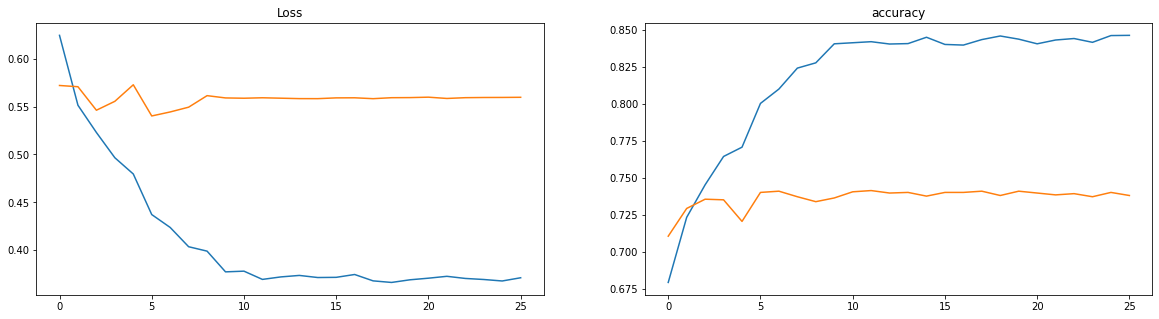

In [66]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 5))
ax[0].plot(fit_data.history['loss'],label="Train")
ax[0].plot(fit_data.history['val_loss'],label="Validation")
ax[0].set_title("Loss")

ax[1].plot(fit_data.history['accuracy'],label="Train")
ax[1].plot(fit_data.history['val_accuracy'],label="Validation")
ax[1].set_title("accuracy")

In [67]:
y_train_predict =  xception_model.predict(X_train_rgb)
y_train_predict = [1 if i >= 0.5 else 0 for i in y_train_predict]


y_test_predict = xception_model.predict(X_test_rgb)
y_test_predict = [1 if i >= 0.5 else 0 for i in y_test_predict]

y_predict = xception_model.predict(X_validate_rgb)
y_predict = [1 if i >= 0.5 else 0 for i in y_predict]


model_name = "xception"
 
metric = {
    "model":model_name,
    "train_score":round(accuracy_score(y_train,y_train_predict),2),
    "test_score":round(accuracy_score(y_test,y_test_predict),2),
    "validate_score":round(accuracy_score(y_validate,y_predict),2),
    "auc":round(roc_auc_score(y_validate,y_predict),2),
    "recall":round(recall_score(y_validate,y_predict),2),
    "precision":round(precision_score(y_validate,y_predict),2),
    "cm":confusion_matrix(y_validate,y_predict)
    }

metrics_data = metrics_data.append(metric,ignore_index = True)
metrics_data[metrics_data["model"] == model_name]

,model,train_score,test_score,validate_score,auc,recall,precision,cm
7,xception,0.88,0.74,0.72,0.72,0.72,0.72,"[[215, 85], [84, 216]]"


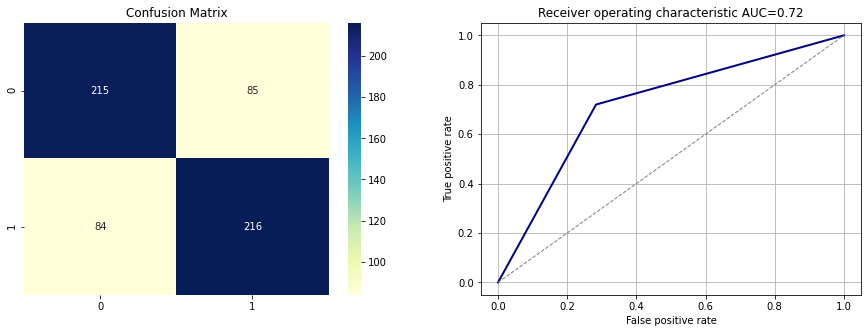

In [68]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(15, 5))
sns.heatmap(confusion_matrix(y_validate,y_predict),annot=True,ax=ax[0],cmap="YlGnBu",fmt="d")
ax[0].set_title('Confusion Matrix'); 
ax[1] = plot_roccurve(y_validate,y_predict)
plt.show() 

### Metrics

In [69]:
metrics_data

,model,train_score,test_score,validate_score,auc,recall,precision,cm
0,NN,0.74,0.68,0.69,0.69,0.92,0.63,"[[135, 165], [23, 277]]"
1,CNN,0.78,0.76,0.70,0.70,0.58,0.76,"[[246, 54], [126, 174]]"
2,VGG16,0.95,0.74,0.72,0.72,0.72,0.72,"[[217, 83], [84, 216]]"
3,VGG19,0.77,0.76,0.74,0.74,0.68,0.78,"[[244, 56], [97, 203]]"
4,ResNet50_V2,0.74,0.73,0.70,0.70,0.70,0.71,"[[213, 87], [90, 210]]"
5,ResNet152,0.76,0.73,0.73,0.73,0.74,0.72,"[[214, 86], [78, 222]]"
6,Inceptionv3,0.91,0.73,0.70,0.70,0.74,0.69,"[[198, 102], [77, 223]]"
7,xception,0.88,0.74,0.72,0.72,0.72,0.72,"[[215, 85], [84, 216]]"
